In [1]:
import pandas as pd
import seaborn as sns
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 12.27)})

In [2]:
original = pd.read_csv('../data/orig.csv')
original['status'] = 'original'
complete = pd.read_csv('../data/complete.csv')
complete['status'] = 'complete'
merged = pd.read_csv('../data/merged.csv')
merged['status'] = 'merged'
split = pd.read_csv('../data/split.csv')
split['status'] = 'split'

In [3]:
def get_changes(datasets):
    agg_datasets = []
    for dataset in datasets:
        df = pd.read_csv(f'../data/{dataset}.csv')
        agg_df = df.groupby('notebook_id').apply(len).to_frame(f'{dataset}_nb_len')
        agg_datasets.append(agg_df.reset_index())

    changes = reduce(lambda left, right: pd.merge(left, right, on='notebook_id', how='left'), agg_datasets)
    changes['percent'] = abs(changes['orig_nb_len'] - changes['complete_nb_len']) / changes['orig_nb_len']
    changes.to_csv(f'../data/changes.csv', index=None)
    return changes


def calc_nb_len_mean(datasets):
    result = {}
    for dataset in datasets:
        result[dataset.status.values[0]] = [dataset.groupby('notebook_id').apply(len).mean()]
    return result


def calc_cell_len_mean(datasets):
    result = {}
    for dataset in datasets:
        result[dataset.status.values[0]] = [dataset.loc[dataset.cell_type == 'code', 'source'].str.split(
            '\n').dropna().apply(len).mean()]
    return result


### Change stats

In [82]:
len(original.notebook_id.unique())

234538

In [111]:
cell_amount = calc_nb_len_mean([original, merged, split, complete])

In [112]:
cell_size = calc_cell_len_mean([original, merged, split, complete])

In [123]:
stats = pd.concat([pd.DataFrame(cell_size), pd.DataFrame(cell_amount)]).T.reset_index()
stats.columns = ['Dataset', 'Mean cell length', 'Mean cell amount']
print(stats)

    Dataset  Mean cell length  Mean cell amount
0  original          8.764119         36.669836
1    merged         11.320019         28.949751
2     split          7.907700         39.881345
3  complete          9.467182         34.523749


In [36]:
datasets = ['orig', 'complete']
changes = get_changes(datasets)

In [89]:
sns.set(rc={'figure.figsize': (6.27, 6.27)})
sns.set_style("whitegrid")

In [81]:
len(changes[changes.percent != 0]) / len(original.notebook_id.unique())

0.8211334623813625

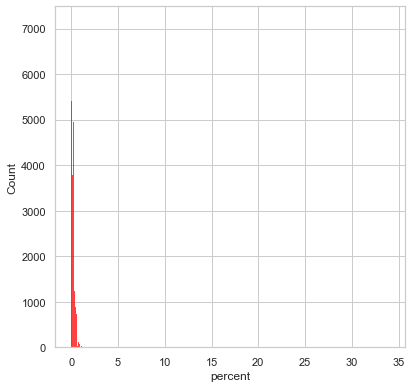

In [97]:
fig = sns.histplot(data=changes[changes.percent != 0], x="percent", color='red')
fig.figure.savefig('../images/percent_change_distribution.pdf', dpi=300)

### Closer look onto merging

In [7]:
merged = merged.dropna(subset=['merged'])
init_ratios = merged.loc[:, ['interlink_ratio']].melt().dropna()
ratios = merged.loc[merged.merged, ['interlink_ratio', 'resulted_intercell_ratio']].melt().dropna()

In [8]:
ratio_change = merged.loc[merged.merged,
                          ['notebook_id', 'interlink_ratio', 'resulted_intercell_ratio']]
ratio_change['inter_change'] = ratio_change['interlink_ratio'] - ratio_change['resulted_intercell_ratio']
ratio_change.sort_values(['inter_change'])

,notebook_id,interlink_ratio,resulted_intercell_ratio,inter_change
1466645,913246,0.200000,0.840000,-0.640000
740240,670167,0.250000,0.857143,-0.607143
4133599,1446559,0.333333,0.918367,-0.585034
6120038,321702,0.326241,0.910891,-0.584650
3991495,1420232,0.333333,0.916667,-0.583333
...,...,...,...,...
3127487,1346492,0.882400,0.211538,0.670862
3321769,1290818,0.759542,0.080292,0.679250
5574494,479484,0.800000,0.120000,0.680000
871354,694615,0.841324,0.125786,0.715538


In [47]:
(ratio_change.inter_change == 0).sum()

282384

In [11]:
init_ratios.to_csv('inter_link_ratio_distribution')

In [12]:
init_ratios

,variable,value
1,interlink_ratio,0.000000
2,interlink_ratio,0.995643
3,interlink_ratio,0.980984
5,interlink_ratio,0.996067
6,interlink_ratio,0.840845
...,...,...
5292847,interlink_ratio,1.000000
5292849,interlink_ratio,0.782609
5292850,interlink_ratio,1.000000
5292851,interlink_ratio,0.852564


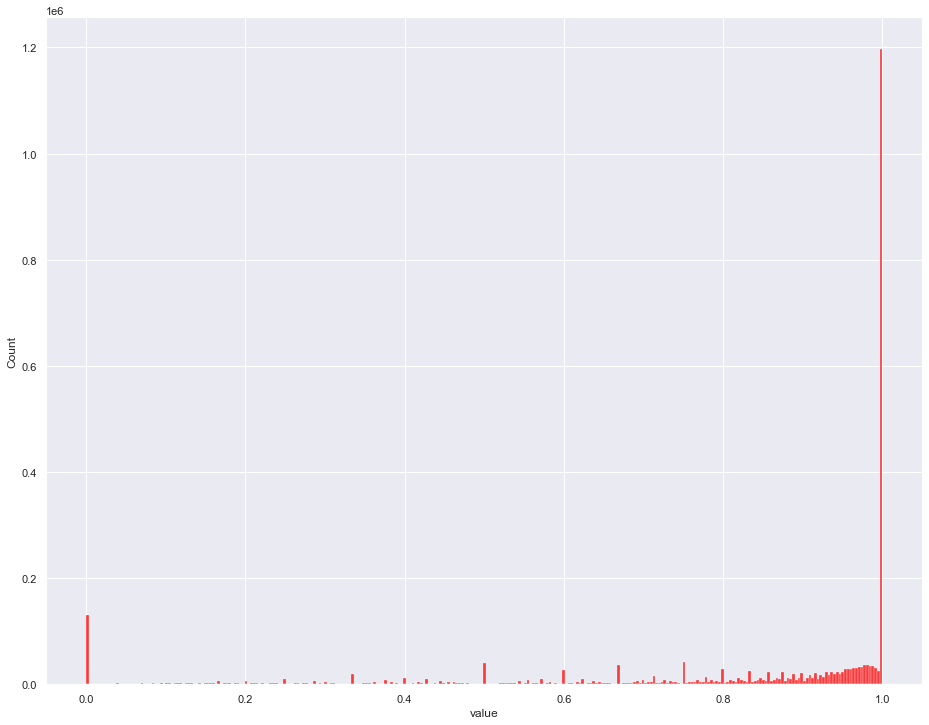

In [9]:

fig = sns.histplot(data=init_ratios, x="value", color='red')
fig.figure.savefig('../images/inter_link_ratio_distribution.pdf', dpi=300)

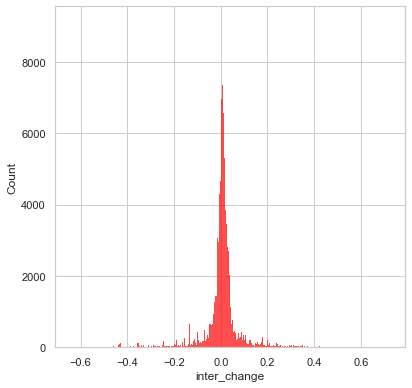

In [96]:
fig = sns.histplot(data=ratio_change[ratio_change.inter_change != 0], x="inter_change", color='red');
fig.figure.savefig('../images/inter_link_ratio_change_distribution.pdf', dpi=300)